<a href="https://colab.research.google.com/github/Dheemant-Dixit/WoC-ML-Bootcamp/blob/main/PolynomialRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Polynomial Regression**
*From scratch using Python*

Polynomial Regression attempts to model the relationship between one or more features and a response by fitting a polynomial equation to the observed data.

Linear regression is a statistical method for modeling relationships between a dependent variable with a given set of independent variables.

### Importing necessary libraries:
Numpy, pandas and matplotlib.

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

### Using Google Drive Mount to access dataset files.

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Loading Data Frame

The famous library 'pandas' is used to load the data frame from the csv files provided.

Data Frame for training dataset.

In [24]:
pd.options.display.max_columns = 5
df_train = pd.read_csv('/content/drive/MyDrive/WoC-ML Bootcamp/Linear and Polynomial Regression/Polynomial_train.csv')
df_train = df_train.drop(columns='Unnamed: 0')      # Dropping the row containing indices by default
df_train.head()

,X,Y,Z,label
0,0.643715,-9.866550,-5.836019,307.972927
1,-1.366446,-3.761945,-8.756162,136.398375
2,-4.090270,-1.836218,-1.846066,-310.724813
3,-8.730478,-1.923651,3.892972,1.755447
4,5.367169,0.358357,6.703989,-343.582590


Data Frame for testing dataset.

In [25]:
df_test = pd.read_csv('/content/drive/MyDrive/WoC-ML Bootcamp/Linear and Polynomial Regression/Polynomial_test.csv')
df_test = df_test.drop(columns=['Unnamed: 0'])      # Dropping the row containing indices by default
df_test.head()

,X,Y,Z,label
0,9.322078,0.413096,5.984731,-657.669309
1,2.811964,6.142752,6.419237,-545.362524
2,-2.669784,7.775091,-6.931907,-75.044187
3,-6.992156,-9.205548,0.852580,-2403.124902
4,1.574294,-2.213266,6.029188,8.595325


## Converting the Data Frame to NumPy Arrays

Using the function `.to_numpy()` to conver the Data Frame to numpy array and then slicing the array to separate features from the label.

`X_train` --> Array with all features of training dataset.

`Y_train` --> Array with all labels of training dataset.

`X_test` --> Array with all features of testing dataset.

`Y_test` --> Array with all labels of testing dataset.

In [26]:
X_train = df_train.to_numpy()
# Number of features:
n = (X_train.shape[1] - 1)
# Number of training examples:
m = X_train.shape[0]
Y_train = X_train[ : , -1]
Y_train = Y_train.reshape(X_train.shape[0], 1)
X_train = X_train[ : , :n]

In [27]:
X_test = df_test.to_numpy()
Y_test = X_test[ : , -1]
Y_test = Y_test.reshape(X_test.shape[0], 1)
X_test = X_test[ : , :n]

## Visualizing Data:

We can change the column number of X to visualize all the features one by one.

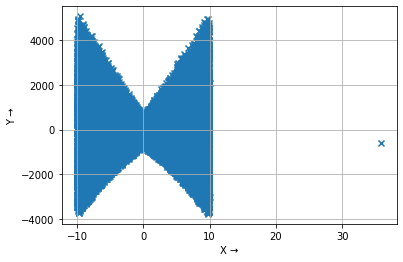

In [28]:
plt.grid(True)
plt.scatter(X_train[:, 0],Y_train, marker = "x")         # The plot is for feature A vs Y
plt.xlabel('X →')
plt.ylabel('Y →')
plt.show()

### Normalising data:

After reviewing the data, I found that all the features were not close to each other, rather they were far apart in values. This will cause gradient descent to be slow.

To fix this problem, the data will be normalised.

For normalisation, mean value of every feature will be subtracted from its value and then it will be scaled by the standard deviation of the respective feature. `.mean` and `.std functions` will be used for the same.

`normalise(X)` --> function for normalisation.

`mu` --> Mean of all the features.

`sigma` --> Standard deviation of all the features.

In [29]:
def normalise(X):
    mu = np.mean(X, axis = 0)       # Mean (Column wise)
    sigma = np.std(X, axis = 0)     # Standard Deviation (Column wise)
    X = X-mu
    X = X/sigma
    return X, mu, sigma

## Polynomial Features:
This function will derive polynomial features out of the features given to us.

Since there are 3 features, we'll try for a cubic polynomial regression.

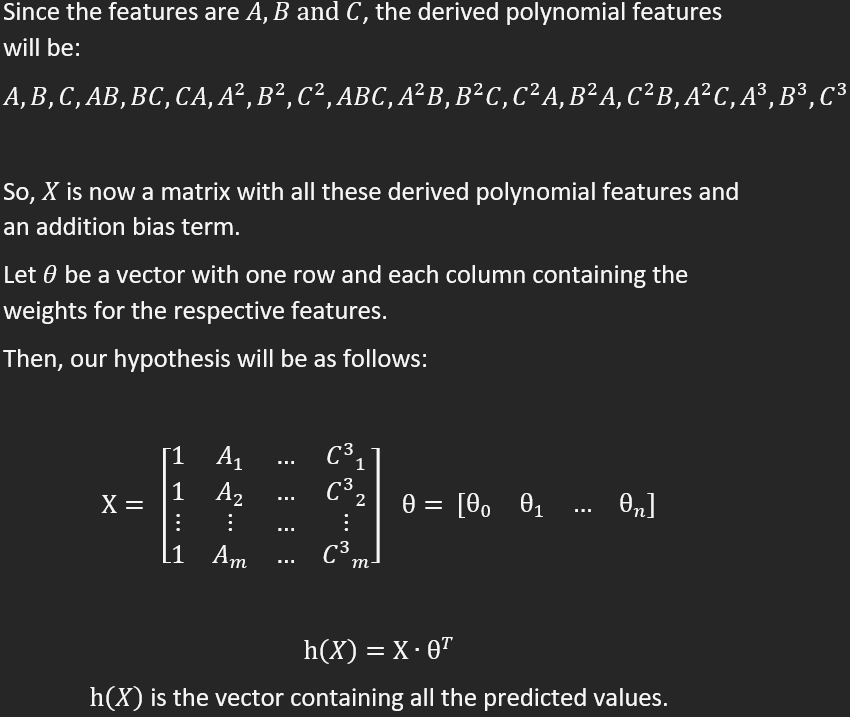

In [30]:
def polynomial(X):
    A = X[:,0]
    B = X[:,1]
    C = X[:,2]
    AB = A*B
    BC = B*C
    CA = C*A
    A2 = A**2
    B2 = B**2
    C2 = C**2
    ABC = AB*C
    A2B = A2*B
    B2C = B2*C
    C2A = C2*A
    B2A = B2*A
    C2B = C2*B
    A2C = A2*C
    A3 = A**3
    B3 = B**3
    C3 = C**3
    X_poly = np.c_[A, B, C, AB, BC, CA, A2, B2, C2, ABC, A2B, B2C, C2A, B2A, C2B, A2C, A3, B3, C3]
    return X_poly

### Changing the features to polynomials:

In [31]:
X_train_poly = polynomial(X_train)
X_test_poly = polynomial(X_test)

### Normalising Data:

In [32]:
global mu, sigma
X_train_poly_norm, mu, sigma = normalise(X_train_poly)
X_test_poly_norm = (X_test_poly-mu)/sigma

### Adding the bias term to the feature array:

In [33]:
extra_column = np.ones((m,1))
X_train_poly_norm = np.c_[extra_column, X_train_poly_norm]
extra_column = np.ones((X_test_poly_norm.shape[0],1))
X_test_poly_norm = np.c_[extra_column, X_test_poly_norm]

Initialising θ to all zero.

In [34]:
theta = np.zeros((1, X_train_poly_norm.shape[1]))    # Vector containing all weights. Initialised to 0.

## Training the Model:
Gradient descent and Back propogation will be used to minimise the Cost Function.

α is Learning Rate.

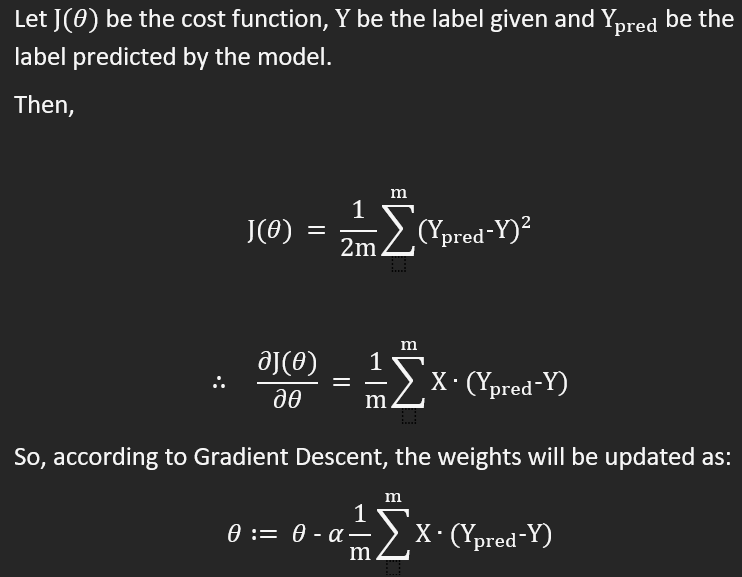

In [35]:
def train_lr (X, Y, X_test, theta, no_of_iterations, learning_rate):
    m_train = X.shape[0]

    grad_arr = np.empty((1, no_of_iterations), float)

    for t in range(no_of_iterations):
        Y_pred = np.dot(X, theta.T)

        loss = (np.sum(Y_pred-Y)**2)/(2*m_train)

        grad = (np.sum(X*(Y_pred-Y), axis=0))/m_train

        grad_arr[(0,t)] = grad[0]

        theta = theta - (learning_rate*grad)

        Y_test = np.dot(X_test, theta.T)

        if (t+1)==100 or (t+1)==300 or (t+1)==500 or (t+1)==750 or (t+1)==1000 or (t+1)==1500 or (t+1)==2000 or (t+1)==2500 or (t+1)==3000:
            print(f"After {t+1} iteraions:")
            print("Loss: ", loss)
            plt.scatter( X[:,5], Y, c='r', marker='x' )        # Change the column of X to obtain graph of different features
            plt.plot(X_test[:,5], Y_test , '-o')
            plt.xlabel('X →')
            plt.ylabel('Y →')
            plt.show()

    print("This plot shows the variation of the gradient with the no. of iteraions, the gradient seems to be approaching 0 as the no. of iteraions increases, as expected")
    plt.grid(True)
    plt.scatter(range(no_of_iterations), grad_arr, marker = "x")
    plt.xlabel('X →')
    plt.ylabel('Y →')
    plt.show()

    return theta

We set α (Learning Rate) to 0.01 and we iterate the model 1500 times for training.

After 100 iteraions:
Loss:  600666.2901677588


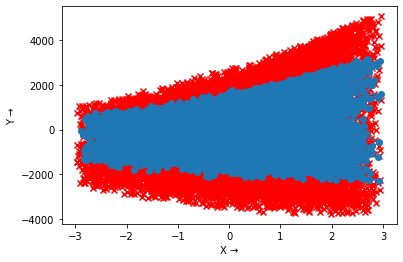

After 300 iteraions:
Loss:  10782.292242183537


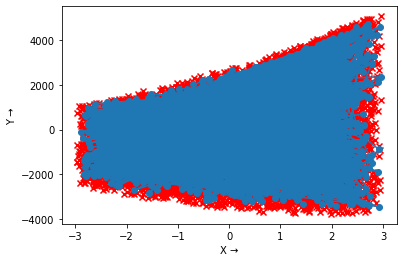

After 500 iteraions:
Loss:  193.54811132043642


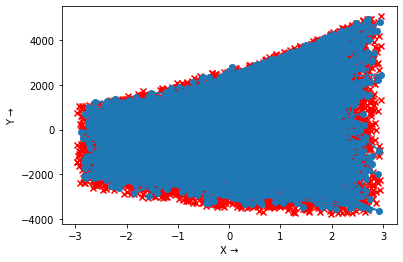

After 750 iteraions:
Loss:  1.271704583322291


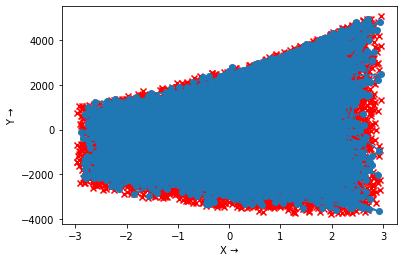

After 1000 iteraions:
Loss:  0.008355713399663206


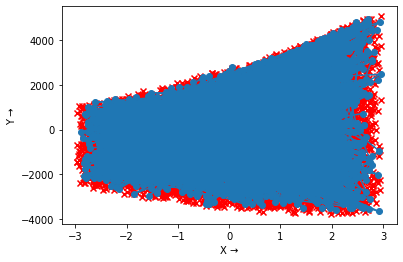

After 1500 iteraions:
Loss:  3.607265705169061e-07


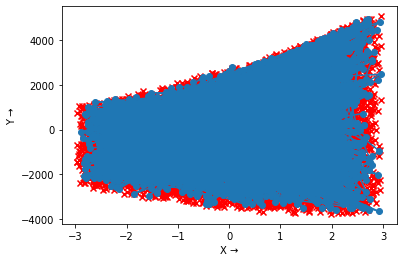

This plot shows the variation of the gradient with the no. of iteraions, the gradient seems to be approaching 0 as the no. of iteraions increases, as expected


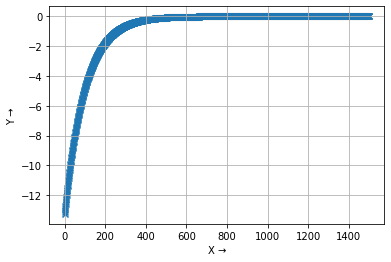

The weights will be:
 [[ 1.32575184e+01 -8.03343786e+00 -9.03949298e-01 -1.63655390e-01
  -1.06693285e+03  2.34621317e+02 -4.67744493e+02  3.10117001e+01
  -1.49643230e+02  1.19314210e+02 -1.57116945e-01  1.28817063e+00
   1.35343646e-01 -6.70454448e-01 -5.44429143e-01  8.29634949e-02
  -1.04215103e+00  1.16075919e+01 -1.36704098e-01  8.16189263e-01]]


In [36]:
global theta
theta = train_lr(X_train_poly_norm, Y_train, X_test_poly_norm, theta, 1500, 0.01)
print('The weights will be:\n',theta)

In [37]:
def predict(X):
    X = polynomial(X)
    X = (X-mu)/sigma
    extra_column = np.ones((X.shape[0],1))
    X = np.c_[extra_column, X]
    result = np.dot(X, theta.T)
    return result

## Accuracy of the Model:

In [38]:
from sklearn.metrics import r2_score
accuracy_train = r2_score(Y_train, predict(X_train))
print('Accuracy of Training dataset is',accuracy_train*100)

accuracy_test = r2_score(Y_test, predict(X_test))
print('Accuracy of Testing dataset is',accuracy_test*100)

Accuracy of Training dataset is 99.99488512020964
Accuracy of Testing dataset is 99.998713570943


## Comparing the Model with sklearn's model:

We'll be comparing with the help of accuracy.

In [39]:
# Accuracy of Training and Testing dataset using sklearn
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model

poly = PolynomialFeatures(degree=3)
poly_variables = poly.fit_transform(X_train)
poly_variables_test = poly.fit_transform(X_test)

regression = linear_model.LinearRegression()

model = regression.fit(poly_variables, Y_train)
score = model.score(poly_variables, Y_train)
print('Accuracy of Training dataset using sklearn is', score*100)
score = model.score(poly_variables_test, Y_test)
print('Accuracy of Testing dataset using sklearn is', score*100)

Accuracy of Training dataset using sklearn is 99.99495018759873
Accuracy of Testing dataset using sklearn is 99.99854091837233


## Polynomial with degree more than 3

We'll be using degree 5 to demonstrate.

### Converting the dataset to polynomial.

`PolynomialFeature()` from `sklearn` will be used to convert the dataset to polynomial.

In [40]:
poly_new = PolynomialFeatures(degree=5)
X_train_new = poly_new.fit_transform(X_train)
print(X_train_new.shape)

X_test_new = poly_new.fit_transform(X_test)
print(X_test_new.shape)

(50000, 56)
(10000, 56)


In [41]:
X_train_new = X_train_new[:, 1:]
print(X_train_new.shape)

X_test_new = X_test_new[:, 1:]
print(X_test_new.shape)

(50000, 55)
(10000, 55)


### Normalising the Data

In [42]:
global mu_, sigma_
X_train_new_norm, mu_, sigma_ = normalise(X_train_new)

X_test_new_norm = (X_test_new-mu_)/sigma_

### Adding the bias term column to the dataset

In [43]:
extra_column = np.ones((X_train_new_norm.shape[0], 1))
X_train_new_norm = np.c_[extra_column, X_train_new_norm]
print(X_train_new_norm)

extra_column = np.ones((X_test_new_norm.shape[0], 1))
X_test_new_norm = np.c_[extra_column, X_test_new_norm]
print(X_test_new_norm)

[[ 1.00000000e+00  1.05754362e-01 -1.69740310e+00 ... -1.13374653e+00
  -5.87566249e-01 -2.25653416e-01]
 [ 1.00000000e+00 -2.42736232e-01 -6.43270345e-01 ... -5.58839954e-01
  -1.13644752e+00 -1.70207804e+00]
 [ 1.00000000e+00 -7.14950633e-01 -3.10738926e-01 ... -5.49220941e-03
   1.85494927e-04 -2.76267141e-03]
 ...
 [ 1.00000000e+00  1.14126721e+00 -4.85328897e-01 ... -4.31460378e-03
   1.27323616e-03 -2.05560178e-03]
 [ 1.00000000e+00  6.11022455e-01  7.84687904e-01 ... -1.37364643e-01
   1.26834099e-01 -8.83078068e-02]
 [ 1.00000000e+00  1.02237771e-01  1.53682418e+00 ... -1.58926770e-01
   5.09800214e-02 -1.36850029e-02]]
[[ 1.00000000e+00  1.61027450e+00  7.76687850e-02 ... -2.11880180e-03
   2.85474454e-02  2.51522014e-01]
 [ 1.00000000e+00  4.81651736e-01  1.06705594e+00 ...  5.78357012e-01
   5.37904427e-01  3.57945916e-01]
 [ 1.00000000e+00 -4.68688892e-01  1.34892546e+00 ... -1.17961602e+00
   9.24891438e-01 -5.30681879e-01]
 ...
 [ 1.00000000e+00  1.14547015e+00  1.1917512

## Training the Model

Alongwith the same method we used before, regularisation will be used to prevent the model from overfitting the training dataset.

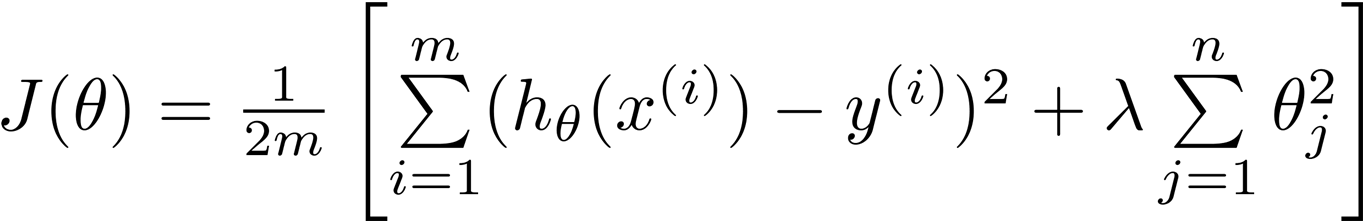

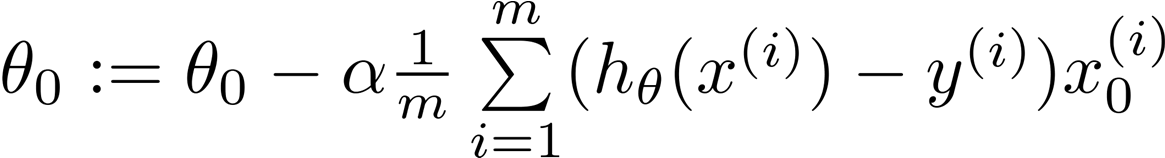

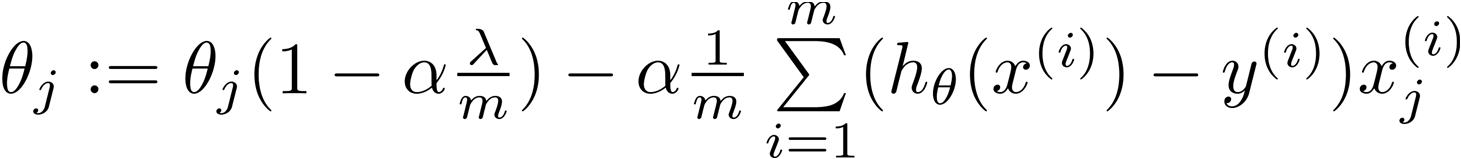

In [44]:
def reg_train_lr (X, Y, X_test, theta, no_of_iterations, learning_rate, reg_constant):
    m_train = X.shape[0]

    grad_arr = np.empty((1, no_of_iterations), float)

    for t in range(no_of_iterations):

        theta_reg = theta
        theta_reg[0][0] = 0

        Y_pred = np.dot(X, theta.T)

        loss = (np.sum((Y_pred-Y)**2)+reg_constant*(theta_reg.T)**2)/(2*m_train)

        grad = (np.sum(X*(Y_pred-Y), axis=0) + (reg_constant*theta_reg))/m_train


        theta = theta - (learning_rate*grad)

        Y_test = np.dot(X_test, theta.T)

        if (t+1)==100 or (t+1)==300 or (t+1)==500 or (t+1)==750 or (t+1)==1000 or (t+1)==1500 or (t+1)==2000 or (t+1)==2500 or (t+1)==3000:
            print(f"After {t+1} iteraions:")
            print("Loss: ", loss[0])
            plt.scatter( X[:,5], Y, c='r', marker='x' )        # Change the column of X to obtain graph of different features
            plt.plot(X_test[:,5], Y_test , '-o')
            plt.xlabel('X →')
            plt.ylabel('Y →')
            plt.show()


    return theta

In [45]:
theta = np.zeros((1, X_train_new_norm.shape[1]))    # Vector containing all weights. Initialised to 0.

After 100 iteraions:
Loss:  [8778.97570204]


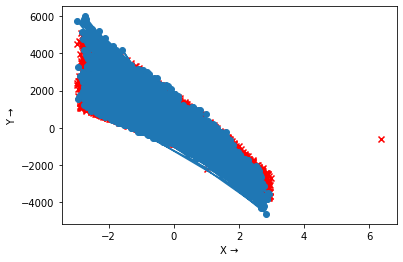

After 300 iteraions:
Loss:  [1173.30863186]


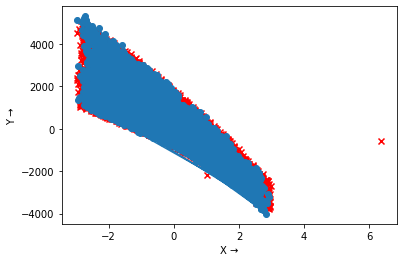

After 500 iteraions:
Loss:  [242.73641761]


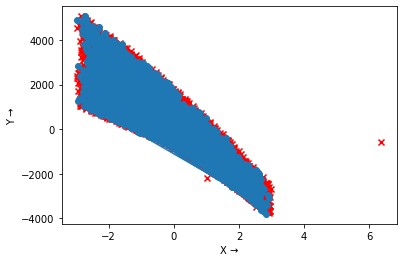

After 750 iteraions:
Loss:  [118.6841666]


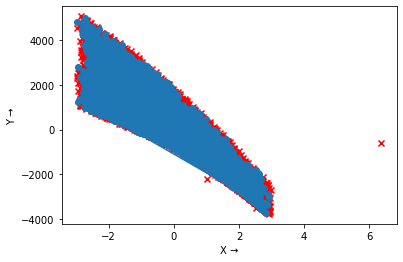

After 1000 iteraions:
Loss:  [108.97649603]


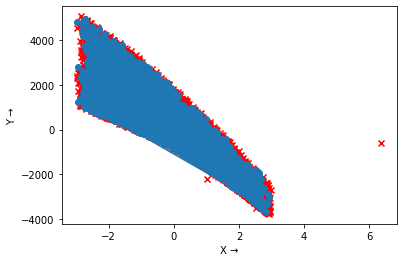

After 1500 iteraions:
Loss:  [108.03263379]


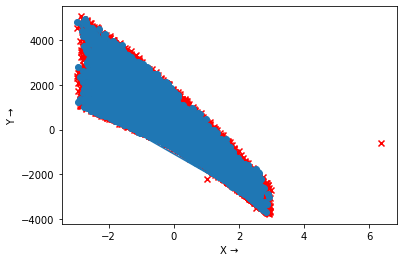

After 2000 iteraions:
Loss:  [108.00086011]


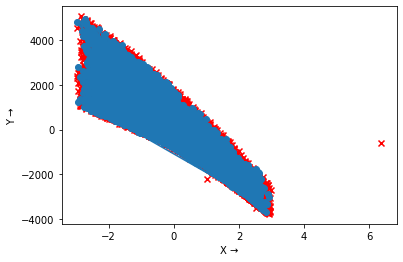

After 2500 iteraions:
Loss:  [107.99090517]


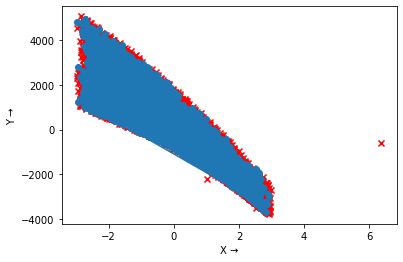

The weights will be:
 [[ 1.32575221e+00  2.83981677e-01 -3.09500633e-01 -6.00688182e-01
   2.96719696e+01 -1.06723929e+03 -4.67689401e+02 -1.49533638e+02
   2.34800231e+02  1.19350146e+02 -1.09614552e+00 -4.92429309e-01
   7.08223834e-01 -3.79889674e-01  1.02069422e-01  2.56528071e-01
   7.22398309e-01  2.10515341e-01  3.37302608e-01  8.72631647e-01
   1.79900683e+00  5.76311400e-02 -6.71763338e-03  9.37570128e-03
  -6.91331546e-02 -1.65795342e-02  7.73976981e-02 -3.46835381e-02
   8.18650889e-02  4.61370806e-02 -1.30871982e-01 -5.62011958e-02
   1.44191503e-02 -7.15693789e-02 -1.68228643e-02  6.67753090e+00
   1.10559966e+00 -1.21626398e+00  6.32364686e-04  1.87054108e-02
  -5.18204082e-02  5.28005382e-02 -1.95938383e-02 -1.10549988e-02
  -1.14242222e-01  3.94160380e-01  1.59969518e-02 -3.58034077e-02
  -1.64871888e-01 -1.67778801e-01 -5.52645771e-01 -1.13578793e-01
   7.04475705e-02 -5.68382032e-02 -2.63358430e-01 -5.11026969e-01]]


In [46]:
global theta
theta = reg_train_lr(X_train_new_norm, Y_train, X_test_new_norm, theta, 2500, 0.1, 0.01)
print('The weights will be:\n',theta)

## Accuracy of the Model:

In [47]:
from sklearn.metrics import r2_score
accuracy_train = r2_score(Y_train, np.dot(X_train_new_norm, theta.T))
print('Accuracy of Training dataset is',accuracy_train*100, '%')

accuracy_test = r2_score(Y_test, np.dot(X_test_new_norm, theta.T))
print('Accuracy of Testing dataset is',accuracy_test*100, '%')

Accuracy of Training dataset is 99.98744196117917 %
Accuracy of Testing dataset is 99.9901771896345 %


## Comparing the Model with sklearn's model:

We'll be comparing with the help of accuracy.

In [48]:
# Accuracy of Training and Testing dataset using sklearn
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model

poly = PolynomialFeatures(degree=5)
poly_variables = poly.fit_transform(X_train)
poly_variables_test = poly.fit_transform(X_test)

regression = linear_model.LinearRegression()

model = regression.fit(poly_variables, Y_train)
score = model.score(poly_variables, Y_train)
print('Accuracy of Training dataset using sklearn is', score*100, '%')
score = model.score(poly_variables_test, Y_test)
print('Accuracy of Testing dataset using sklearn is', score*100, '%')

Accuracy of Training dataset using sklearn is 99.99723691149386 %
Accuracy of Testing dataset using sklearn is 99.99999537507315 %
